# Queensland Road Traffic and Crash Data Insights 2021-2024

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import re
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
spark = SparkSession.builder.appName("QLD_Traffic_Crash_Data").getOrCreate()
sc = spark.sparkContext

crash_pth = "1_crash_locations.csv" #https://www.data.qld.gov.au/dataset/crash-data-from-queensland-roads/resource/e88943c0-5968-4972-a15f-38e120d72ec0
roads_pth = "road-location-and-traffic-data_20250629.csv" #https://www.data.qld.gov.au/dataset/road-location-and-traffic-data/resource/daab3617-077f-450a-a1c0-57c26d8ba47c
census_pth = "aadt_2014_2024.csv" #https://www.data.qld.gov.au/dataset/traffic-census-for-the-queensland-state-declared-road-network/resource/b856deab-ab20-48f1-85c6-2715e3a1d42c?inner_span=True
traffic_pths = [
               "qld-traffic-data-average-by-hour-by-day-2021_updated.csv", #https://www.data.qld.gov.au/dataset/queensland-traffic-data-averaged-by-hour-of-day-and-day-of-week/resource/44fe23b4-8519-4b3f-a24c-6a76b0076c81?inner_span=True
               "qld-traffic-data-average-by-hour-by-day-2022.csv", #https://www.data.qld.gov.au/dataset/queensland-traffic-data-averaged-by-hour-of-day-and-day-of-week/resource/4d70bf41-d61e-40c6-86ce-9e61565483a4?inner_span=True
               "qld-traffic-data-average-by-hour-by-day-2023.csv", #https://www.data.qld.gov.au/dataset/queensland-traffic-data-averaged-by-hour-of-day-and-day-of-week/resource/d2428b1b-8e3c-4850-828a-f356c5387a0b?inner_span=True
               "qld-traffic-data-average-by-hour-by-day-2024.csv" #https://www.data.qld.gov.au/dataset/queensland-traffic-data-averaged-by-hour-of-day-and-day-of-week/resource/ef3b4602-696a-4a8b-9934-c1f76e147834
               ]
hdfs_pth = "hdfs://namenode:9000/nbs/"

>**Read CSV's and clean columns.**

In [3]:
#Reading and Unioning each yearly average traffic data csv.
traffic_df = spark.read.csv(hdfs_pth+traffic_pths[0], header=True, inferSchema=True).withColumn("Year", F.lit(int(re.findall(r'(\d{4})', traffic_pths[0])[0])))
for pth in traffic_pths[1:]:
    yearly_df = spark.read.csv(hdfs_pth+pth, header=True, inferSchema=True).withColumn("Year", F.lit(int(re.findall(r'(\d{4})', pth)[0])))
    traffic_df = traffic_df.unionByName(yearly_df)
print("Total Traffic Records: ", traffic_df.count())
#Drop unnecessary columns
traffic_df = traffic_df.drop('DESCRIPTION', 'SITE_DISTANCE', 'TDIST_START',
    'TDIST_END', 'GAZETTAL_DIRECTION', 'WEEKDAY_AVERAGE', 'WEEKEND_AVERAGE')
#Lowercase all column names
for c in traffic_df.columns:
    traffic_df = traffic_df.withColumnRenamed(c, c.lower())
print("Traffic DF Columns: ", traffic_df.columns)

#Read crash data csv
crash_df = spark.read.csv(hdfs_pth+crash_pth, header=True, inferSchema=True)
print("\nTotal Crash Records: ", crash_df.count())
#Drop unnecessary columns
crash_df = crash_df.drop('Crash_Nature', 'Crash_Type', 'Crash_Street', 
    'Crash_Street_Intersecting', 'Loc_Suburb', 'Loc_Local_Government_Area',
    'Loc_Post_Code', 'Loc_Police_Division', 'Loc_Police_District', 
    'Loc_Police_Region','Loc_Queensland_Transport_Region', 
    'Loc_Main_Roads_Region','Loc_ABS_Statistical_Area_2', 
    'Loc_ABS_Statistical_Area_3','Loc_ABS_Statistical_Area_4',
    'Loc_ABS_Remoteness', 'Loc_State_Electorate','Loc_Federal_Electorate',
    'Crash_Controlling_Authority','Crash_Roadway_Feature', 
    'Crash_Traffic_Control', 'Crash_Road_Surface_Condition',
    'Crash_Atmospheric_Condition', 'Crash_Lighting_Condition',
    'Crash_Road_Horiz_Align', 'Crash_Road_Vert_Align', 'Crash_DCA_Code',
    'Crash_DCA_Description', 'Crash_DCA_Group_Description',
    'Crash_DCA_Key_Approach_Dir', 'Count_Casualty_MedicallyTreated',
    'Count_Casualty_MinorInjury', 'Count_Casualty_Hospitalised',
    'Count_Unit_Car', 'Count_Unit_Motorcycle_Moped', 'Count_Unit_Truck',
    'Count_Unit_Bus', 'Count_Unit_Bicycle', 'Count_Unit_Pedestrian',
    'Count_Unit_Other')
#Lowercase all column names
for c in crash_df.columns:
    crash_df = crash_df.withColumnRenamed(c, c.lower())
print("Crash DF Columns: ", crash_df.columns)

#Read road data csv
roads_df = spark.read.csv(hdfs_pth+roads_pth, header=True, inferSchema=True)
print("\nTotal Roads Records: ", roads_df.count())
#Drop unnecessary columns
roads_df = roads_df.drop('Carriageway_Code', 'Tdist_Start', 'AADT_Intervention_Category')
#Lowercase all column names
for c in roads_df.columns:
    roads_df = roads_df.withColumnRenamed(c, c.lower())
roads_df = roads_df.withColumnRenamed("road_section_id", "rsect_id")
print("Roads DF Columns: ", roads_df.columns)

#Read census data csv
census_df = spark.read.csv(hdfs_pth+census_pth, header=True, inferSchema=True)
print("\nTotal Census Records: ", census_df.count())
#Drop unnecessary columns
census_df = census_df.drop('COLLECTION_YEAR','SITE_TYPE','DESCRIPTION',
    'SITE_THROUGH_DISTANCE','SEG_START_THROUGH_DISTANCE',
    'SEG_END_THROUGH_DISTANCE','SEG_LONGITUDE_START','SEG_LATITUDE_START',
    'SEG_LONGITUDE_END','SEG_LATITUDE_END','DISTRICT_ID','REGION_ID',
    'LGA_ID','AADT_CLASS_0B', 'AADT_CLASS_1A', 'AADT_CLASS_1B', 
    'AADT_CLASS_1C','AADT_CLASS_1D', 'AADT_CLASS_2A', 'AADT_CLASS_2B', 
    'AADT_CLASS_2C','AADT_CLASS_2D', 'AADT_CLASS_2E', 'AADT_CLASS_2F', 
    'AADT_CLASS_2G','AADT_CLASS_2H', 'AADT_CLASS_2I', 'AADT_CLASS_2J', 
    'AADT_CLASS_2K','AADT_CLASS_2L', 'PC_CLASS_1A', 'PC_CLASS_1B', 
    'PC_CLASS_1C', 'PC_CLASS_1D', 'PC_CLASS_2A', 'PC_CLASS_2B', 'PC_CLASS_2C',
    'PC_CLASS_2D', 'PC_CLASS_2E', 'PC_CLASS_2F', 'PC_CLASS_2G', 'PC_CLASS_2H',
    'PC_CLASS_2I', 'PC_CLASS_2J', 'PC_CLASS_2K', 'PC_CLASS_2L', 
    'GROWTH_PC_1YR', 'GROWTH_PC_5YR', 'GROWTH_PC_10YR')
#Lowercase all column names
for c in census_df.columns:
    census_df = census_df.withColumnRenamed(c, c.lower())
census_df = census_df.withColumnRenamed("road_section_id", "rsect_id")
print("Census DF Columns: ", census_df.columns)

raw_record_count = traffic_df.count()+crash_df.count()+roads_df.count()+census_df.count()
print("\nTotal number of records (Raw): ",  raw_record_count)

Total Traffic Records:  325416
Traffic DF Columns:  ['site_id', 'longitude', 'latitude', 'rsect_id', 'road_name', 'hours', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'year']

Total Crash Records:  408271
Crash DF Columns:  ['crash_ref_number', 'crash_severity', 'crash_year', 'crash_month', 'crash_day_of_week', 'crash_hour', 'crash_longitude', 'crash_latitude', 'state_road_name', 'crash_speed_limit', 'dca_key_approach_dir', 'count_casualty_fatality', 'count_casualty_total']

Total Roads Records:  3601483
Roads DF Columns:  ['rsect_id', 'latitude', 'longitude', 'description', 'aadt']

Total Census Records:  74616
Census DF Columns:  ['traffic_year', 'rsect_id', 'road_name', 'site_id', 'speed_limit', 'site_latitude', 'site_longitude', 'district_name', 'region_name', 'lga_name', 'travel_direction', 'aadt', 'aadt_class_0a', 'pc_class_0a', 'pc_class_0b']

Total number of records (Raw):  4409786


>**Clean row data.**

In [4]:
print("Total Traffic Records Pre-Clean: ", traffic_df.count())
#Remove null rows.
traffic_df = traffic_df.na.drop(how='all')
traffic_df = traffic_df.filter(~F.col("site_id").isNull() &
                               ~F.col("rsect_id").isNull() &
                               ~F.col("longitude").isNull() & 
                               ~F.col("latitude").isNull())
# Convert 'hours' column format from "x 'to' y" to "y" ie. 00:00 to 01:00 == 1.
traffic_df = traffic_df.withColumn(
    "hours", F.regexp_extract(F.col("hours"), r'to\s*(\d+)', 1).cast("int"))
#Cast columns with inconsistent types.
traffic_df = traffic_df.withColumn("longitude", F.col("longitude").cast("double"))
traffic_df = traffic_df.withColumn("latitude", F.col("latitude").cast("double"))
traffic_df = traffic_df.filter((F.col("latitude") >= -29.5) & (F.col("latitude") <= -9) &
                               (F.col("longitude") >= 138) & (F.col("longitude") <= 155))
#traffic_df = traffic_df.withColumn("rsect_id", F.col("rsect_id").cast("int"))
days = ["mon","tue","wed","thu","fri","sat","sun"]
for day in days:
    traffic_df = traffic_df.withColumn(day, F.col(day).cast("int"))
    
print("Total Traffic Records Post-Clean: ", traffic_df.count())

print("Total Crash Records Pre-Clean: ", crash_df.count())
#Remove null rows.
crash_df = crash_df.na.drop(how='all')
#Filter out years not in scope.
crash_df = crash_df.withColumn("crash_year", F.col("crash_year").cast("int"))
crash_df = crash_df.filter(F.col("crash_year") >= 2021)
crash_df = crash_df.filter(~F.col("crash_longitude").isNull() &
                           ~F.col("crash_latitude").isNull() &
                           ~F.col("crash_severity").isNull())
#Cast columns with inconsistent types.
crash_df = crash_df.withColumn("crash_longitude", F.col("crash_longitude").cast("double"))
crash_df = crash_df.withColumn("crash_latitude", F.col("crash_latitude").cast("double"))
crash_df = crash_df.withColumn("crash_speed_limit", F.col("crash_speed_limit").cast("int"))
#Normalise hour to '1' = 00:00 to 01:00
crash_df = crash_df.withColumn("crash_hour", F.col("crash_hour") + 1)
print("Total Crash Records Post-Clean: ", crash_df.count())

print("Total Roads Records Pre-Clean: ", roads_df.count())
#Remove null rows.
roads_df = roads_df.na.drop(how='all')
roads_df = roads_df.filter(~F.col("rsect_id").isNull() &
                           ~F.col("latitude").isNull() &
                           ~F.col("longitude").isNull())
#Cast columns with inconsistent types.
roads_df = roads_df.withColumn("longitude", F.col("longitude").cast("double"))
roads_df = roads_df.withColumn("latitude", F.col("latitude").cast("double"))
#roads_df = roads_df.withColumn("rsect_id", F.col("rsect_id").cast("int"))

print("Total Roads Records Post-Clean: ", roads_df.count())

print("Total Census Records Pre-Clean: ", census_df.count())
#Remove null rows.
census_df = census_df.na.drop(how='all')
#Filter out years not in scope.
census_df = census_df.withColumn("traffic_year", F.col("traffic_year").cast("int"))
census_df = census_df.filter(F.col("traffic_year") >= 2021)
census_df = census_df.filter(~F.col("rsect_id").isNull() &
                             ~F.col("aadt").isNull() &
                             ~F.col("site_latitude").isNull() &
                             ~F.col("site_longitude").isNull())
#Cast columns with inconsistent types.
census_df = census_df.withColumn("site_longitude", F.col("site_longitude").cast("double"))
census_df = census_df.withColumn("site_latitude", F.col("site_latitude").cast("double"))
#census_df = census_df.withColumn("rsect_id", F.col("rsect_id").cast("int"))

print("Total Census Records Post-Clean: ", census_df.count())
clean_record_count = traffic_df.count()+crash_df.count()+roads_df.count()+census_df.count()
print("\nTotal number of records (Clean): ", clean_record_count, "\nNumber of records removed: ", raw_record_count - clean_record_count)

Total Traffic Records Pre-Clean:  325416
Total Traffic Records Post-Clean:  313368
Total Crash Records Pre-Clean:  408271
Total Crash Records Post-Clean:  54366
Total Roads Records Pre-Clean:  3601483
Total Roads Records Post-Clean:  3601483
Total Census Records Pre-Clean:  74616
Total Census Records Post-Clean:  27681

Total number of records (Clean):  3996898 
Number of records removed:  412888


>**Associating Each Crash with a Road Section ID.**

In [5]:
#Function for calculating distance between two coordinates on a sphere (globe)
def haversine_distance(lat1, lon1, lat2, lon2):
    R = F.lit(6371)  # Earth's radius in km
    dlat = F.radians(lat2 - lat1)
    dlon = F.radians(lon2 - lon1)
    a = (
        F.pow(F.sin(dlat / 2), 2) +
        F.cos(F.radians(lat1)) * F.cos(F.radians(lat2)) *
        F.pow(F.sin(dlon / 2), 2)
    )
    c = 2 * F.atan2(F.sqrt(a), F.sqrt(1 - a))
    return R * c

In [6]:

# Find average coordinates of rsect ids.
rsect_location_avg = roads_df.groupBy("rsect_id").agg(F.avg("longitude").alias("avg_longitude"),F.avg("latitude").alias("avg_latitude"))

padding = 0.25

#Centroids within 'padding' degrees of each crash 
crash_location = (
    crash_df.alias("c")
    .join(F.broadcast(rsect_location_avg).alias("r"),
          on=[(F.col("c.crash_latitude").between(F.col("r.avg_latitude")- padding,
                                                 F.col("r.avg_latitude") + padding)) &
              (F.col("c.crash_longitude").between(F.col("r.avg_longitude") - padding,
                                                  F.col("r.avg_longitude") + padding))],
          how="left").withColumn("dist_km", haversine_distance(F.col("c.crash_latitude"),
                                                                F.col("c.crash_longitude"),
                                                                F.col("r.avg_latitude"),
                                                                F.col("r.avg_longitude")))
    .select("c.*", F.col("r.rsect_id").alias("possible_rsect_id"), "dist_km")
)
w = Window.partitionBy("crash_ref_number").orderBy(F.col("dist_km").asc())
# Ranks each possible rsect_id by distance from centroid, keeps only closest
crash_df_with_rsect = (
    crash_location
      .withColumn("rn", F.row_number().over(w))
      .filter(F.col("rn") == 1)
      .drop("rn")
      .withColumn(
          "rsect_id",
          F.col("possible_rsect_id")
      )
      .drop("possible_rsect_id")
)
crash_df_with_rsect.select("crash_ref_number", 'dist_km', 'rsect_id').show()
crash_df = crash_df_with_rsect

+----------------+------------------+--------+
|crash_ref_number|           dist_km|rsect_id|
+----------------+------------------+--------+
|           70355|3.9633024907057606|    8509|
|           71527|2.0197793611014814|     406|
|           72578|  1.33589445944026|     U32|
|           72702| 1.068836187462781|    150A|
|           72758| 3.311916700904339|     127|
|           72820| 1.841316033754206|    U29A|
|           73048|0.7886679571833634|    U28C|
|           73091| 0.743211936265249|    9905|
|           73683| 9.278566118613101|     10B|
|           73933| 6.942580411178157|     852|
|           74058| 9.333393569166248|     490|
|           74281| 3.434083191768327|     12A|
|           76110| 11.68376989948991|    3203|
|           76143|6.3310077866080965|    2302|
|           80006|3.1859321464119037|    150A|
|           80033| 6.088745301436657|     314|
|           81349|1.1389251423762783|    C053|
|           84812|2.7706802914249744|    4104|
|           8

In [7]:
traffic_df.write.csv("hdfs://namenode:9000/nbs/clean/traffic_clean.csv", header=True)
crash_df.write.csv("hdfs://namenode:9000/nbs/clean/crash_clean.csv", header=True)
roads_df.write.csv("hdfs://namenode:9000/nbs/clean/roads_clean.csv", header=True)
census_df.write.csv("hdfs://namenode:9000/nbs/clean/census_clean.csv", header=True)

>**Data Summary.**

In [8]:
print("Traffic Table Schema")
traffic_df.printSchema()
print("Crash Table Schema")
crash_df.printSchema()
print("Road Table Schema")
roads_df.printSchema()
print("Census Table Schema")
census_df.printSchema()

print("\nTraffic Data Summary")
traffic_df.select('rsect_id', 'site_id', 'longitude', 'latitude').describe().show(truncate=False)
print("Crash Data Summary")
crash_df.select('rsect_id','crash_ref_number','crash_longitude', 'crash_latitude').describe().show(truncate=False)
print("Road Data Summary")
roads_df.select('rsect_id', 'aadt', 'longitude', 'latitude').describe().show(truncate=False)
print("Census Data Summary")
census_df.select('rsect_id', 'site_id', 'site_longitude', 'site_latitude').describe().show(truncate=False)

Traffic Table Schema
root
 |-- site_id: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- rsect_id: string (nullable = true)
 |-- road_name: string (nullable = true)
 |-- hours: integer (nullable = true)
 |-- mon: integer (nullable = true)
 |-- tue: integer (nullable = true)
 |-- wed: integer (nullable = true)
 |-- thu: integer (nullable = true)
 |-- fri: integer (nullable = true)
 |-- sat: integer (nullable = true)
 |-- sun: integer (nullable = true)
 |-- year: integer (nullable = false)

Crash Table Schema
root
 |-- crash_ref_number: integer (nullable = true)
 |-- crash_severity: string (nullable = true)
 |-- crash_year: integer (nullable = true)
 |-- crash_month: string (nullable = true)
 |-- crash_day_of_week: string (nullable = true)
 |-- crash_hour: integer (nullable = true)
 |-- crash_longitude: double (nullable = true)
 |-- crash_latitude: double (nullable = true)
 |-- state_road_name: string (nullable = true)
 |-- c

In [9]:
traffic_df.createOrReplaceTempView("traffic")
roads_df.createOrReplaceTempView("roads")
census_df.createOrReplaceTempView("census")
crash_df.createOrReplaceTempView("crash")

>**QLD Road Fatalities by Year.**

+----+------+
|year|fatals|
+----+------+
|2021|   246|
|2022|   273|
|2023|   261|
|2024|   273|
+----+------+



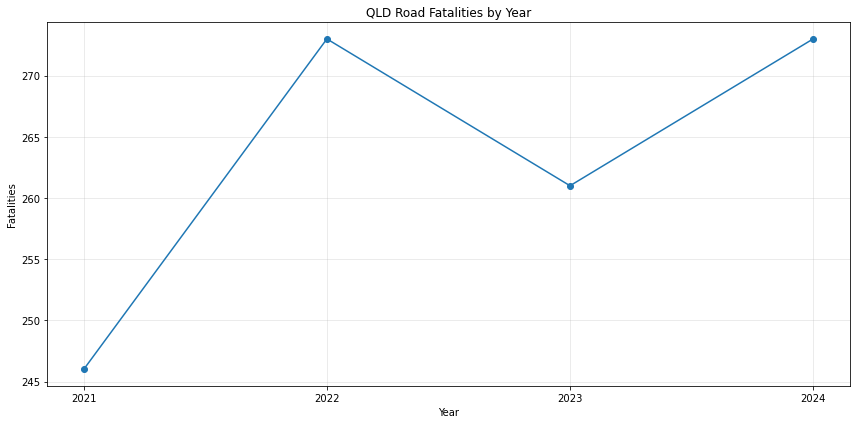

In [10]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW fatalities_by_year AS
SELECT 
    crash_year AS year, 
    SUM(CASE WHEN crash_severity = 'Fatal' THEN 1 ELSE 0 END) AS fatals
FROM crash
GROUP BY year
ORDER BY year ASC""")
spark.sql("""select * from fatalities_by_year""").show()
pdf = spark.sql("""select * from fatalities_by_year""").toPandas()
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(pdf["year"], pdf["fatals"], marker='o')

ax.set_title("QLD Road Fatalities by Year")
ax.set_xlabel("Year")
ax.set_ylabel("Fatalities")
ax.set_xticks([2021, 2022, 2023, 2024])
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

>**Crash Rate Trend for Each Road Section, Based on Average Yearly Crashes Per Million Vehicles**

+--------+----+--------------------+--------+-------+------+-------------------+------------------+-----------+--------+
|rsect_id|year|           road_name|aadt_avg|crashes|fatals|crashes_per_million|fatals_per_million|avg_crashes| avg_cpm|
+--------+----+--------------------+--------+-------+------+-------------------+------------------+-----------+--------+
|    U28C|2024|SOUTH EAST BUSWAY...|   246.0|     87|     0|            968.927|               0.0|       92.0|1024.613|
|    U28C|2023|SOUTH EAST BUSWAY...|   246.0|     93|     1|            1035.75|            11.137|       92.0|1024.613|
|    U28C|2022|SOUTH EAST BUSWAY...|   246.0|     92|     0|           1024.613|               0.0|       92.0|1024.613|
|    U28C|2021|SOUTH EAST BUSWAY...|   246.0|     96|     1|           1069.161|            11.137|       92.0|1024.613|
|    3401|2024|DAANDINE - NANDI ...| 116.667|     26|     0|            610.568|               0.0|      22.75| 672.624|
|    3401|2023|DAANDINE - NANDI 

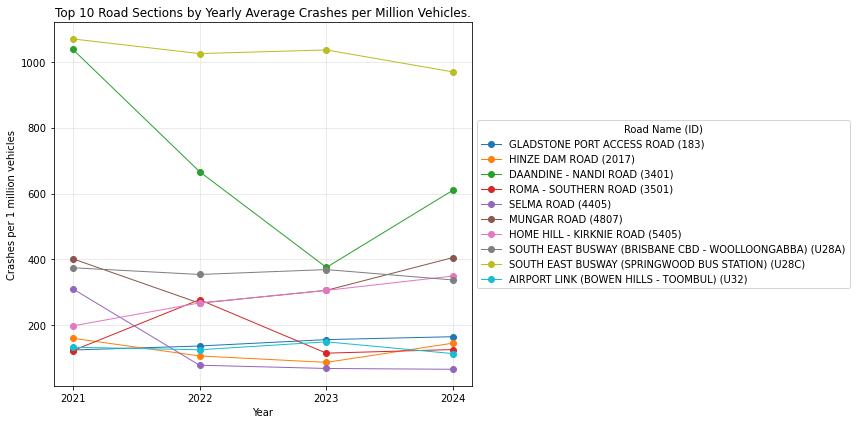

In [11]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW crash_rate_view AS
SELECT
    *,
    ROUND(AVG(crashes) OVER (PARTITION BY rsect_id), 3) AS avg_crashes,
    ROUND(AVG(crashes_per_million) OVER (PARTITION BY rsect_id), 3) AS avg_cpm
FROM (
    SELECT
        c.rsect_id,
        c.year,
        MAX(a.road_name) AS road_name,
        ROUND(MAX(a.aadt_avg), 3) AS aadt_avg,
        SUM(c.crashes)   AS crashes,
        SUM(c.fatals)    AS fatals,
        ROUND((SUM(c.crashes) / (MAX(a.aadt_avg) * 365.0)) * 1e6, 3) AS crashes_per_million,
        ROUND((SUM(c.fatals)  / (MAX(a.aadt_avg) * 365.0)) * 1e6, 3) AS fatals_per_million
    FROM (
        SELECT
            rsect_id,
            crash_year AS year,
            COUNT(*) AS crashes,
            SUM(CASE WHEN crash_severity = 'Fatal' THEN 1 ELSE 0 END) AS fatals
        FROM crash
        WHERE rsect_id IS NOT NULL
        GROUP BY rsect_id, crash_year
    ) c
    JOIN (
        SELECT
            rsect_id,
            traffic_year AS year,
            MAX(road_name) AS road_name,
            AVG(aadt) AS aadt_avg
        FROM census
        GROUP BY rsect_id, traffic_year
    ) a ON c.rsect_id = a.rsect_id AND c.year = a.year
    GROUP BY c.rsect_id, c.year
)
ORDER BY avg_cpm DESC, year DESC;""")
spark.sql("SELECT * FROM crash_rate_view WHERE avg_crashes >= 10 LIMIT 40").show()

pdf = spark.sql("""
SELECT rsect_id, year, road_name, crashes_per_million
FROM crash_rate_view
WHERE avg_crashes >= 10
LIMIT 40
""").toPandas()
fig, ax = plt.subplots(figsize=(12, 6))
for rid, grp in pdf.groupby('rsect_id'):
    ax.plot(grp['year'], grp['crashes_per_million'], marker='o', label=f"{grp['road_name'].iloc[0]} ({rid})", linewidth=1)

ax.set_title("Top 10 Road Sections by Yearly Average Crashes per Million Vehicles.")
ax.set_xlabel("Year")
ax.set_ylabel("Crashes per 1 million vehicles")
ax.set_xticks([2021, 2022, 2023, 2024])
ax.legend(title="Road Name (ID)", loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

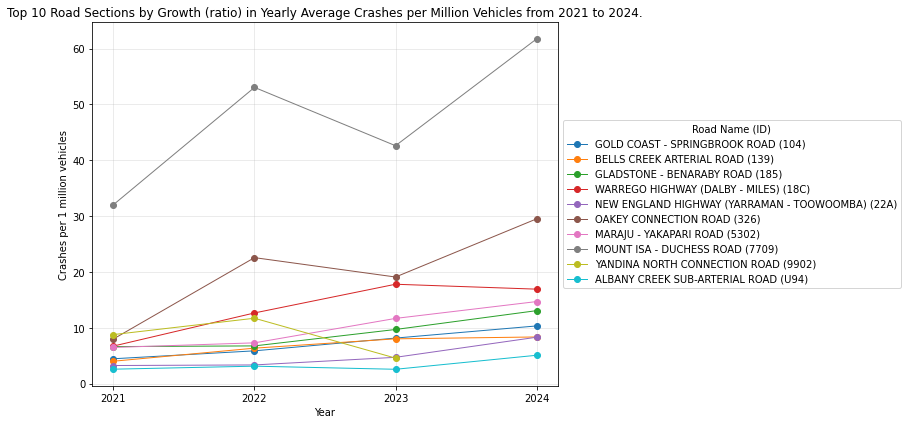

In [12]:
pdf = spark.sql("""
SELECT 
    c.rsect_id,
    c.year,
    c.road_name,
    c.crashes_per_million
FROM crash_rate_view c
JOIN (
    SELECT
        a.rsect_id,
        (b.crashes_per_million / a.crashes_per_million) AS ratio
    FROM crash_rate_view a
    JOIN crash_rate_view b ON a.rsect_id = b.rsect_id
    WHERE a.year = 2021 AND b.year = 2024 AND a.crashes_per_million > 0
) d ON d.rsect_id = c.rsect_id
WHERE c.avg_crashes >= 10
ORDER BY d.ratio DESC, c.rsect_id, c.year
LIMIT 39;""").toPandas()

fig, ax = plt.subplots(figsize=(12, 6))
for rid, grp in pdf.groupby('rsect_id'):
    ax.plot(grp['year'], grp['crashes_per_million'], marker='o', label=f"{grp['road_name'].iloc[0]} ({rid})", linewidth=1)

ax.set_title("Top 10 Road Sections by Growth (ratio) in Yearly Average Crashes per Million Vehicles from 2021 to 2024.")
ax.set_xlabel("Year")
ax.set_ylabel("Crashes per 1 million vehicles")
ax.set_xticks([2021, 2022, 2023, 2024])
ax.legend(title="Road Name (ID)", loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

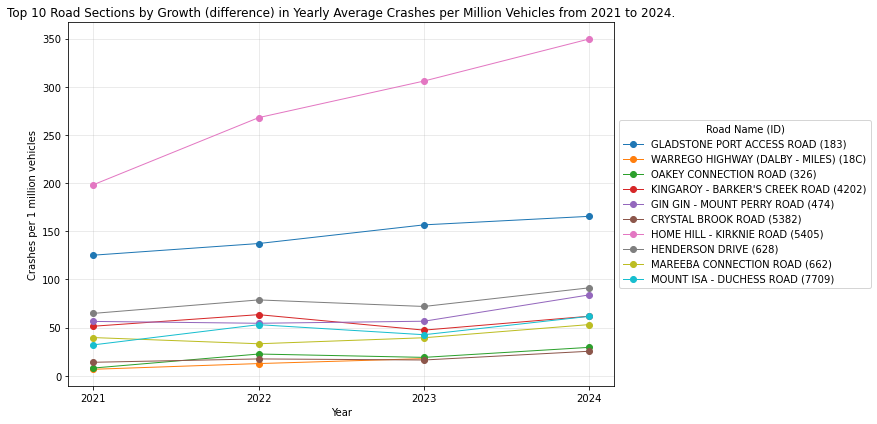

In [13]:
pdf = spark.sql("""
SELECT 
    c.rsect_id,
    c.year,
    c.road_name,
    c.crashes_per_million
FROM crash_rate_view c
JOIN (
    SELECT
        a.rsect_id,
        (b.crashes_per_million - a.crashes_per_million) AS diff
    FROM crash_rate_view a
    JOIN crash_rate_view b ON a.rsect_id = b.rsect_id
    WHERE a.year = 2021 AND b.year = 2024 AND a.crashes_per_million > 0
) d ON d.rsect_id = c.rsect_id
WHERE c.avg_crashes >= 10
ORDER BY d.diff DESC, c.rsect_id, c.year
LIMIT 39;""").toPandas()

fig, ax = plt.subplots(figsize=(12, 6))
for rid, grp in pdf.groupby('rsect_id'):
    ax.plot(grp['year'], grp['crashes_per_million'], marker='o', label=f"{grp['road_name'].iloc[0]} ({rid})", linewidth=1)

ax.set_title("Top 10 Road Sections by Growth (difference) in Yearly Average Crashes per Million Vehicles from 2021 to 2024.")
ax.set_xlabel("Year")
ax.set_ylabel("Crashes per 1 million vehicles")
ax.set_xticks([2021, 2022, 2023, 2024])
ax.legend(title="Road Name (ID)", loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

>**Hourly Crash Rate (Crashes per Million Vehicles) by Year.**

+----+----+-------+----------------+-------------------+
|year|hour|crashes|average_vehicles|crashes_per_million|
+----+----+-------+----------------+-------------------+
|2024|   3|    714|       20978.714|          34034.498|
|2024|   1|   1088|       36884.000|          29497.885|
|2024|   2|    626|       28021.143|          22340.274|
|2024|   4|    742|       38645.286|          19200.272|
|2024|  24|   1137|       77478.000|          14675.134|
|2024|   5|    770|       68228.714|          11285.571|
|2024|  23|   1565|      146128.286|          10709.768|
|2024|  21|   2639|      297028.571|           8884.667|
|2024|  22|   1982|      226900.714|           8735.098|
|2024|  20|   2552|      358315.000|           7122.225|
|2024|  19|   3985|      604887.857|           6587.998|
|2024|  17|   5722|     1125321.857|           5084.767|
|2024|  18|   4902|      970685.286|            5050.04|
|2024|  16|   5877|     1167545.714|           5033.636|
|2024|   9|   5173|     1105961

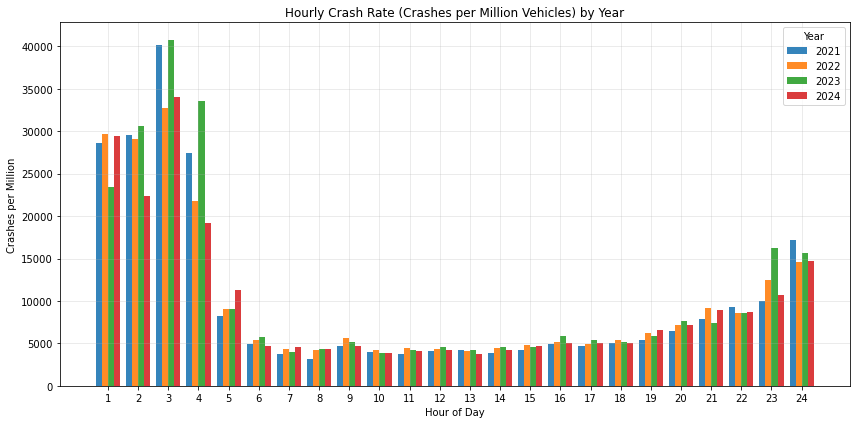

In [14]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW hourly_crash_rate_view AS
SELECT 
    v.year,
    v.hour,
    IFNULL(SUM(c.crash_count),0) AS crashes,
    ROUND(SUM(v.avg_hourly_vehicles), 3) AS average_vehicles,
    ROUND(IFNULL((SUM(c.crash_count) / NULLIF(SUM(v.avg_hourly_vehicles),0)),0) * 1e6, 3) AS crashes_per_million
FROM (
    SELECT 
        rsect_id,
        year,
        hours AS hour,
        (mon + tue + wed + thu + fri + sat + sun)/7.0 AS avg_hourly_vehicles
    FROM traffic
    WHERE rsect_id IS NOT NULL
) v
JOIN (
    SELECT 
        rsect_id,
        crash_year AS year,
        crash_hour AS hour,
        COUNT(*) AS crash_count
    FROM crash
    WHERE rsect_id IS NOT NULL AND crash_hour IS NOT NULL
    GROUP BY rsect_id, crash_year, crash_hour
) c ON v.rsect_id = c.rsect_id AND v.year = c.year AND v.hour = c.hour
GROUP BY v.year, v.hour
ORDER BY v.year DESC, crashes_per_million DESC;""")
spark.sql("SELECT * FROM hourly_crash_rate_view LIMIT 24").show()

pdf = spark.sql("""
  SELECT year, hour, crashes_per_million
  FROM hourly_crash_rate_view
""").toPandas()

pdf["hour"] = pdf["hour"].astype(int)
hours = np.arange(1,25)
years = np.sort(pdf["year"].unique())

# Bar layout params (grouped bars like your earlier chart, but same structure as the HV example)
group_width = 0.8
n_years = len(years)
bar_width = group_width / n_years

# 3) Plot — same feel: fig/ax first, then direct ax.bar(...) calls from pdf
fig, ax = plt.subplots(figsize=(12, 6))


for i, yr in enumerate(years):
    df_y = pdf[pdf["year"] == yr][["hour", "crashes_per_million"]]
    vals = (df_y.set_index("hour")["crashes_per_million"].reindex(hours).to_numpy())
    offset = (i - (n_years - 1) / 2) * bar_width
    ax.bar(hours + offset, vals, width=bar_width, label=str(yr), alpha=0.9)

ax.set_xlabel("Hour of Day")
ax.set_ylabel("Crashes per Million")
ax.set_title("Hourly Crash Rate (Crashes per Million Vehicles) by Year")
ax.set_xticks(hours)
ax.grid(True, alpha=0.3)
ax.legend(title="Year")

plt.tight_layout()
plt.show()

>**Crash Severity by Heavy Vehicle Share.**

+------------------+--------------+-------------+-----------+
|hv_percentile_band|severe_crashes|total_crashes|severe_rate|
+------------------+--------------+-------------+-----------+
|             0–10%|          4603|        10093|      0.456|
|            10–20%|          4161|         9025|      0.461|
|            20–30%|          2780|         5507|      0.505|
|            30–40%|          3077|         5929|      0.519|
|            40–50%|          2421|         4531|      0.534|
|            50–60%|          1559|         2591|      0.602|
|            60–70%|          1283|         2027|      0.633|
|            70–80%|           884|         1319|       0.67|
|            80–90%|           726|         1162|      0.625|
|           90–100%|           867|         1399|       0.62|
+------------------+--------------+-------------+-----------+



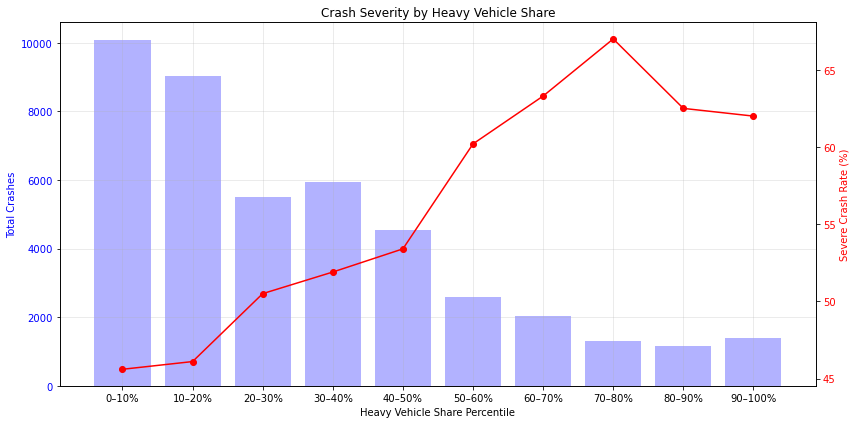

In [15]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW heavy_vehicle_crash_severity AS
SELECT
    FORMAT_STRING('%s–%s%%', (band-1)*10, band*10) AS hv_percentile_band,
    SUM(severe_crashes) AS severe_crashes,
    SUM(all_crashes)    AS total_crashes,
    ROUND(SUM(severe_crashes) / SUM(all_crashes), 3) AS severe_rate
FROM (
    SELECT
        *,
        NTILE(10) OVER (ORDER BY hv_share_pc) AS band
    FROM (
        SELECT
            c.rsect_id, c.year,
            c.all_crashes, c.severe_crashes,
            hv.hv_share_pc
        FROM (
            SELECT
                rsect_id,
                crash_year AS year,
                COUNT(*) AS all_crashes,
                COUNT_IF(crash_severity IN ('Fatal','Hospitalisation')) AS severe_crashes
            FROM crash
            GROUP BY rsect_id, crash_year
        ) c
        JOIN (
            SELECT
                rsect_id,
                traffic_year AS year,
                AVG(pc_class_0b) AS hv_share_pc
            FROM census
            GROUP BY rsect_id, traffic_year
        ) hv ON c.rsect_id = hv.rsect_id AND c.year = hv.year
    )
)
GROUP BY band
ORDER BY band;""")
spark.sql("SELECT * FROM heavy_vehicle_crash_severity").show()

pdf = spark.sql("""
SELECT hv_percentile_band, severe_rate, total_crashes
FROM heavy_vehicle_crash_severity
""").toPandas()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(pdf["hv_percentile_band"], pdf["total_crashes"], 
        alpha=0.3, color='blue', label='Total Crashes')
ax1.set_ylabel("Total Crashes", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel("Heavy Vehicle Share Percentile")
ax1.grid(True, alpha=0.3, zorder=0)

ax2 = ax1.twinx()
ax2.plot(pdf["hv_percentile_band"], pdf["severe_rate"]*100, 
         marker='o', color='red')
ax2.set_ylabel("Severe Crash Rate (%)", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Crash Severity by Heavy Vehicle Share")
plt.tight_layout()
plt.show()

>**Crash risk by speed limit.**

+-----------+-------+-------------------+-----------+
|speed_limit|crashes|crashes_per_million|severe_rate|
+-----------+-------+-------------------+-----------+
|        110|    706|              3.143|      0.518|
|        100|  14868|              8.528|      0.582|
|         90|   1273|              6.355|       0.52|
|         80|  12833|             10.661|      0.478|
|         70|   5369|             10.729|      0.458|
|         60|   7142|             15.037|      0.493|
+-----------+-------+-------------------+-----------+



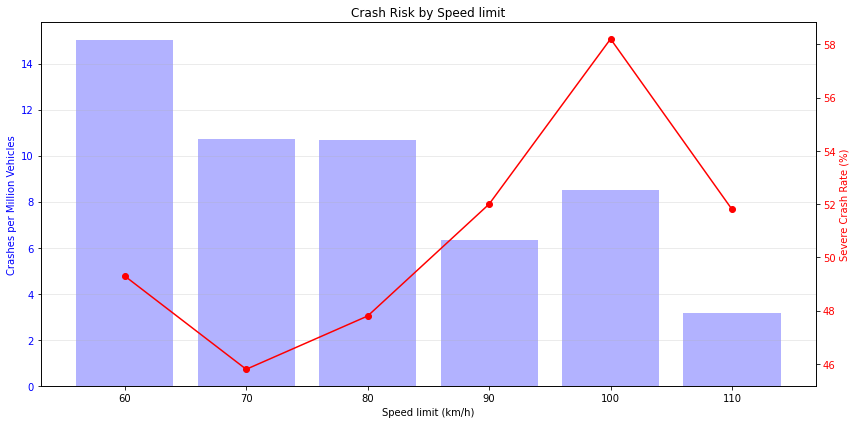

In [16]:
spark.sql("""
CREATE OR REPLACE TEMP VIEW speed_limit_effect AS
SELECT 
    s.speed_limit,
    SUM(c.crashes) AS crashes,
    ROUND((SUM(c.crashes) / SUM(s.aadt_avg * 365.0)) * 1e6, 3) AS crashes_per_million,
    ROUND((SUM(c.severe_crashes) / SUM(c.crashes)), 3) AS severe_rate
FROM (
    SELECT 
        rsect_id,
        traffic_year AS year,
        MAX(speed_limit) AS speed_limit,
        AVG(aadt) AS aadt_avg
    FROM census
    WHERE speed_limit IS NOT NULL AND aadt IS NOT NULL
    GROUP BY rsect_id, traffic_year
) s
JOIN (
    SELECT 
        rsect_id,
        crash_year AS year, COUNT(*) AS crashes,
        COUNT_IF(crash_severity IN ('Fatal','Hospitalisation')) AS severe_crashes
    FROM crash
    WHERE rsect_id IS NOT NULL
    GROUP BY rsect_id, crash_year
) c ON s.rsect_id=c.rsect_id AND s.year=c.year
WHERE s.aadt_avg > 0
GROUP BY s.speed_limit
ORDER BY s.speed_limit DESC;""")
spark.sql("SELECT * FROM speed_limit_effect LIMIT 20").show()

pdf = spark.sql("""
SELECT speed_limit, crashes, crashes_per_million, severe_rate
FROM speed_limit_effect
""").toPandas().sort_values('speed_limit')

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bars behind
ax1.bar(pdf['speed_limit'].astype(str), pdf['crashes_per_million'],
        alpha=0.3, color='blue')
ax1.set_ylabel('Crashes per Million Vehicles', color='blue')
ax1.set_xlabel('Speed limit (km/h)')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, axis='y', alpha=0.3)

# Line in front
ax2 = ax1.twinx()
ax2.plot(pdf['speed_limit'].astype(str), pdf['severe_rate']*100, 
         marker='o', color='red')
ax2.set_ylabel('Severe Crash Rate (%)', color='red' )
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Crash Risk by Speed limit')
plt.tight_layout()
plt.show()